# Index Benchmarking on PGVector (IVFFlat vs HNSW)

When your embedding table grows into millions of rows, brute-force search (no index) can become painfully slow.

PGVector offers **two advanced index types** to speed up similarity search:
- **IVFFlat** — Inverted File Index
- **HNSW** — Hierarchical Navigable Small World Graph

In this tutorial, we’ll:

* Generate **1 Mn** embeddings  
* Benchmark search with **no index**, **IVFFlat**, and **HNSW**  
* Compare query speed 
* Understand when to use which index

Prerequisite:
* [PostgreSQL + PGVector](https://www.youtube.com/watch?v=erNoI9COOn0&t=3s)

Let’s get started...

### Install Dependencies

In [ ]:
# Run this cell to install required packages (if not already installed)
!pip install psycopg2-binary pandas python-dotenv openai tqdm

## 1. Setup (DB Connection & Imports)

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
import psycopg2
import psycopg2.extras
import pandas as pd
#from tqdm import tqdm
from tqdm.auto import tqdm
import time

from openai import OpenAI

import matplotlib.pyplot as plt

%matplotlib inline

tqdm.pandas()

# Load .env if present
print("Environment Variables Loaded? ", load_dotenv())

DB_CONFIG = {
    "host": os.getenv("PG_HOST", "localhost"),
    "port": os.getenv("PG_PORT", "5432"),
    "dbname": os.getenv("PG_DATABASE", "postgres"),
    "user": os.getenv("PG_USER", "postgres"),
    "password": os.getenv("PG_PASS", "postgres"),
}

Environment Variables Loaded?  True


### 1.1 Test DB Connection

In [2]:
def get_connection(autocommit=True):
    connection = psycopg2.connect(**DB_CONFIG)
    connection.autocommit=autocommit
    cursor = connection.cursor()

    return connection, cursor
    
# Quick connection test
try:
    connection, cursor = get_connection()
    print("Connected to PostgreSQL")
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Connected to PostgreSQL


### 1.2 Embeddings Generation LLM

In [3]:
client = OpenAI(
    base_url='http://localhost:11434/v1', ## OpenAI URL 
    api_key="",  ## os.environ["OPENAI_API_KEY"]
)

def get_embedding(text):
    response = client.embeddings.create(
        model="all-minilm",  ## bge-m3, bge-large, embeddinggemma, qwen3-embedding, open AI embedding model, etc.
        input=text
    )
    return response.data[0].embedding

embed = get_embedding("test text")

print(f"Embeddings Length: {len(embed)}")

Embeddings Length: 384


## 2. Load Dataset

* **[Full TMDB Movies Dataset 2024 (1M Movies)](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies)**
    * The TMDb (The Movie Database) is a comprehensive movie database that provides information about movies, including details like titles, ratings, release dates, revenue, genres, and much more.
    * This dataset contains a collection of 1,000,000 movies from the TMDB database.



In [4]:
%%time

tmdb_movies_df = pd.read_csv("TMDB_movie_dataset_v11.csv") ## nrows=100_000

print(f"#Rows   : {tmdb_movies_df.shape[0]:,}")
#print(f"\nColumns : {tmdb_movies_df.columns}\n")

tmdb_movies_df = tmdb_movies_df[["imdb_id", "title", "release_date", "runtime", "overview", "genres"]]
tmdb_movies_df["release_date"] = pd.to_datetime(tmdb_movies_df["release_date"])
tmdb_movies_df["release_date"] = tmdb_movies_df["release_date"].replace({pd.NaT: None})
tmdb_movies_df["runtime"] = tmdb_movies_df["runtime"].fillna(-1)
tmdb_movies_df["genres"] = tmdb_movies_df["genres"].fillna("")
tmdb_movies_df["overview"] = tmdb_movies_df["overview"].fillna("").str[:200] ## Applied 200 character limit because our local embeddings LLM fails with context size error with very long strings.
tmdb_movies_df["title"] = tmdb_movies_df["title"].fillna("")

tmdb_movies_df.head()

#Rows   : 1,319,465
CPU times: user 3.86 s, sys: 229 ms, total: 4.09 s
Wall time: 4.09 s


,imdb_id,title,release_date,runtime,overview,genres
0,tt1375666,Inception,2010-07-15 00:00:00,148,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure"
1,tt0816692,Interstellar,2014-11-05 00:00:00,169,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction"
2,tt0468569,The Dark Knight,2008-07-16 00:00:00,152,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller"
3,tt0499549,Avatar,2009-12-15 00:00:00,162,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction"
4,tt0848228,The Avengers,2012-04-25 00:00:00,143,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure"


## 3. Create Table for Embeddings

In [5]:
try:
    connection, cursor = get_connection()

    cursor.execute("DROP TABLE IF EXISTS movie_embeddings;")
    cursor.execute("""
    CREATE TABLE movie_embeddings (
        id SERIAL PRIMARY KEY,
        title TEXT,
        genres TEXT,
        overview TEXT,
        runtime SMALLINT,
        release_date TIMESTAMP,
        embedding vector(384)
    );
    """)

    print("Table 'movie_embeddings' created with 384-dim vector column.")
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Table 'movie_embeddings' created with 384-dim vector column.


## 4. Generate Embeddings and Insert into DB

### 4.1 Generate Embeddings

In [6]:
%%time

tmdb_movies_df["embedding"] = (
    "Title: " + tmdb_movies_df["title"] +\
    "\nDescription: " + tmdb_movies_df["overview"] +\
    "\nGenres: " + tmdb_movies_df["genres"]
).progress_apply(get_embedding)

tmdb_movies_df.head()

  0%|          | 0/1319465 [00:00<?, ?it/s]

CPU times: user 54min 12s, sys: 5min 15s, total: 59min 28s
Wall time: 8h 4min 29s


,imdb_id,title,release_date,runtime,overview,genres,embedding
0,tt1375666,Inception,2010-07-15 00:00:00,148,"Cobb, a skilled thief who commits corporate es...","Action, Science Fiction, Adventure","[-0.09028839319944382, 0.06784045696258545, -0..."
1,tt0816692,Interstellar,2014-11-05 00:00:00,169,The adventures of a group of explorers who mak...,"Adventure, Drama, Science Fiction","[-0.02879920043051243, -0.05886845663189888, 0..."
2,tt0468569,The Dark Knight,2008-07-16 00:00:00,152,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller","[-0.0007033771253190935, 0.014036901295185089,..."
3,tt0499549,Avatar,2009-12-15 00:00:00,162,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Science Fiction","[0.010565309785306454, 0.048339586704969406, 0..."
4,tt0848228,The Avengers,2012-04-25 00:00:00,143,When an unexpected enemy emerges and threatens...,"Science Fiction, Action, Adventure","[-0.0603812150657177, -0.0022996249608695507, ..."


### 4.2 Insert Embeddings in Table

In [7]:
%%time

insert_sql = """
INSERT INTO movie_embeddings (title, genres, overview, runtime, release_date, embedding)
VALUES %s
"""

try:
    connection, cursor = get_connection(autocommit=False) ## autocommit set to False for faster insertion

    psycopg2.extras.execute_values(
        cursor, insert_sql,
        tmdb_movies_df[["title", "genres", "overview", "runtime", "release_date", "embedding"]].values,
        page_size=10_000
    )
    
    ## Commit after all rows are updated
    connection.commit()

except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

CPU times: user 4min 50s, sys: 12.7 s, total: 5min 2s
Wall time: 1h 45min 40s


## 5. Define Search Function

In [4]:
def search(query_emb, limit=10):
    """
    Finds matching movies to user query embeddings.
    """
    try:
        connection, cursor = get_connection()

        cursor.execute(
            "SELECT title, embedding <=> %s AS distance FROM movie_embeddings ORDER BY embedding <=> %s LIMIT %s",
            (str(query_emb), str(query_emb), limit)
        )
        rows = cursor.fetchall()
        return pd.DataFrame(rows, columns=["Title", "Distance"])
    except Exception as e:
        print("Connection failed:", e)
    finally:
        cursor.close()
        connection.close()

## 6. Benchmark without Index

In [7]:
query_emb = get_embedding("Movie about astronaut lost in space")

start = time.time()

results = search(query_emb)

no_index_time = time.time() - start

print(f"Query time (no index): {no_index_time:.4f}s")

results

Query time (no index): 2.1266s


,Title,Distance
0,Lost In Space,0.219026
1,The Astronaut,0.280320
2,The Spacefarer's Lament,0.297766
3,Lost in Space,0.333414
4,The Astronaut,0.337008
5,Followed Back,0.344691
6,Origin,0.351153
7,Dead Astronaut,0.351665
8,The Stranger,0.351890
9,Falling Astronaut,0.372107


## 7. IVFFlat Index

**IVFFlat** stands for **Inverted File with Flat Quantization** —  
it’s a clustering-based approach to accelerate nearest neighbor search.

Instead of comparing your query vector to *every row* (brute force),  
PostgreSQL with IVFFlat first assigns all embeddings into **clusters** (called *lists*).  
Then, during search, it compares the query only with vectors inside a few closest clusters.

### Key Parameters

| Parameter | Description | Typical Range | Trade-off |
|------------|--------------|----------------|------------|
| **lists** | Number of clusters (centroids) | 50–1000 | Higher = better recall, slower search & larger index |
| **probes** | How many clusters to search at query time | 1–20 | Higher = better accuracy, slower speed |


### How It Works (Simplified)
1. During index creation, your vectors are partitioned into *lists* using k-means clustering.  
2. When you run a search, PGVector finds the `probes` closest lists to your query.  
3. It only compares vectors inside those lists instead of the whole table.



### Notes
- You **must run `ANALYZE`** after creating the IVFFlat index so PGVector learns the cluster statistics.  
- Increasing `lists` improves recall but increases index size and build time.  
- Increasing `probes` improves recall but increases query latency.


In [10]:
%%time

try:
    connection, cursor = get_connection()

    cursor.execute("DROP INDEX IF EXISTS movie_embedding_ivfflat;")
    
    # IVFFlat requires 'lists' parameter (number of clusters)
    cursor.execute("""
    CREATE INDEX movie_embedding_ivfflat
    ON movie_embeddings
    USING ivfflat (embedding vector_cosine_ops)
    WITH (lists = 100);
    """)
    
    print("IVFFlat index created.")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

IVFFlat index created.
CPU times: user 9.49 ms, sys: 12.9 ms, total: 22.4 ms
Wall time: 1min 5s


## 8. Analyze Table (Required for IVFFlat)

In [11]:
%%time

try:
    connection, cursor = get_connection()
    cursor.execute("ANALYZE movie_embeddings;")
    
    print("Table analyzed (IVFFlat requires this before search).")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Table analyzed (IVFFlat requires this before search).
CPU times: user 7.06 ms, sys: 3.55 ms, total: 10.6 ms
Wall time: 3.3 s


## 9. Benchmark IVFFlat Search

In [12]:
query_emb = get_embedding("Movie about astronaut lost in space")

try:
    connection, cursor = get_connection()
    
    # Control number of probes (more probes => better accuracy, slower)
    cursor.execute("SET ivfflat.probes = 10;") # The table is divided into 100 clusters, and each search checks 10 of them.

    start = time.time()
    results_ivf = search(query_emb)
    ivfflat_time = time.time() - start
    
    print(f"Query time (IVFFlat): {ivfflat_time:.4f}s")
    
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

results_ivf

Query time (IVFFlat): 0.0365s


,Title,Distance
0,Lost In Space,0.219026
1,The Astronaut,0.280320
2,The Spacefarer's Lament,0.297766
3,Lost in Space,0.333414
4,The Astronaut,0.337008
5,Followed Back,0.344691
6,Origin,0.351153
7,Dead Astronaut,0.351665
8,The Stranger,0.351890
9,Falling Astronaut,0.372107


## 10. Create HNSW Index

**HNSW** stands for **Hierarchical Navigable Small World Graph** —  
it’s a **graph-based** approach for **approximate nearest neighbor (ANN)** search.

Instead of dividing vectors into clusters (like IVFFlat),  
HNSW builds a **multi-layer graph** where each node (vector) connects to its nearest neighbors.  
During search, PostgreSQL walks this graph efficiently to find the closest matches.

### Key Parameters

| Parameter | Description | Typical Range | Trade-off |
|------------|--------------|----------------|------------|
| **m** | Number of bi-directional links per node | 8–32 | Higher = better recall, more memory usage |
| **ef_construction** | Search depth during index building | 40–200 | Higher = better accuracy, slower index build |
| **ef_search** | Search depth during querying | 20–200 | Higher = better recall, slower query speed |

### How It Works (Simplified)
1. Vectors are inserted into a **hierarchical graph**.  
2. The **top layers** connect distant nodes for quick navigation.  
3. The **lower layers** connect close neighbors for precise search.  
4. The algorithm starts from the top and "walks" down the graph toward the nearest region.

This multi-level graph design makes HNSW extremely fast and accurate —  
especially when you need **high recall with low latency**.

### Notes
- HNSW generally provides **higher recall (accuracy)** than IVFFlat at similar speed.  
- It’s **incrementally updatable** — you can insert new vectors anytime.  
- It **consumes more memory** since each node stores neighbor connections.  
- Best suited for **semantic search, recommendations**, and **real-time retrieval**.


In [13]:
%%time

try:
    connection, cursor = get_connection()
    
    cursor.execute("DROP INDEX IF EXISTS movie_embedding_ivfflat;")
    cursor.execute("DROP INDEX IF EXISTS movie_embedding_hnsw;")
    
    cursor.execute("""
    CREATE INDEX movie_embedding_hnsw
    ON movie_embeddings
    USING hnsw (embedding vector_cosine_ops)
    WITH (m = 16, ef_construction = 64);
    """)
    
    print("HNSW index created.")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

HNSW index created.
CPU times: user 72.4 ms, sys: 40.5 ms, total: 113 ms
Wall time: 24min 30s


## 11. Benchmark HNSW Search

In [14]:
query_emb = get_embedding("Movie about astronaut lost in space")

try:
    connection, cursor = get_connection()

    # Control ef_search (larger => more accurate, slower)
    cursor.execute("SET hnsw.ef_search = 40;")
    # Each node connects to 16 neighbors (denser graph = higher accuracy).
    # During queries, PostgreSQL explores 40 candidates per search — balancing recall and speed.
    
    start = time.time()
    results_hnsw = search(query_emb)
    hnsw_time = time.time() - start
    
    print(f"Query time (HNSW): {hnsw_time:.4f}s")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

results_hnsw

Query time (HNSW): 0.0795s


,Title,Distance
0,Lost In Space,0.219026
1,The Astronaut,0.280320
2,The Spacefarer's Lament,0.297766
3,Lost in Space,0.333414
4,The Astronaut,0.337008
5,Followed Back,0.344691
6,Origin,0.351153
7,Dead Astronaut,0.351665
8,The Stranger,0.351890
9,Alone In Space,0.372295


## 12. Compare Query Times

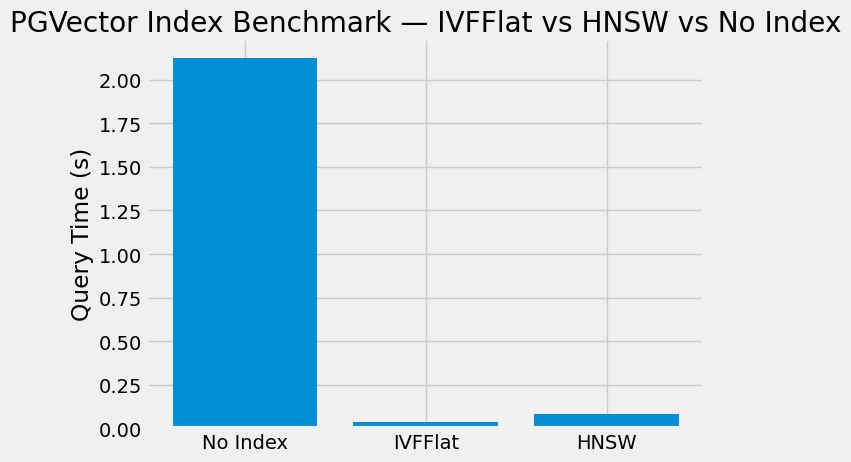

In [11]:
with plt.style.context("fivethirtyeight"):
    plt.bar(["No Index", "IVFFlat", "HNSW"], [no_index_time, ivfflat_time, hnsw_time])
    plt.ylabel("Query Time (s)")
    plt.title("PGVector Index Benchmark — IVFFlat vs HNSW vs No Index")
    plt.show()

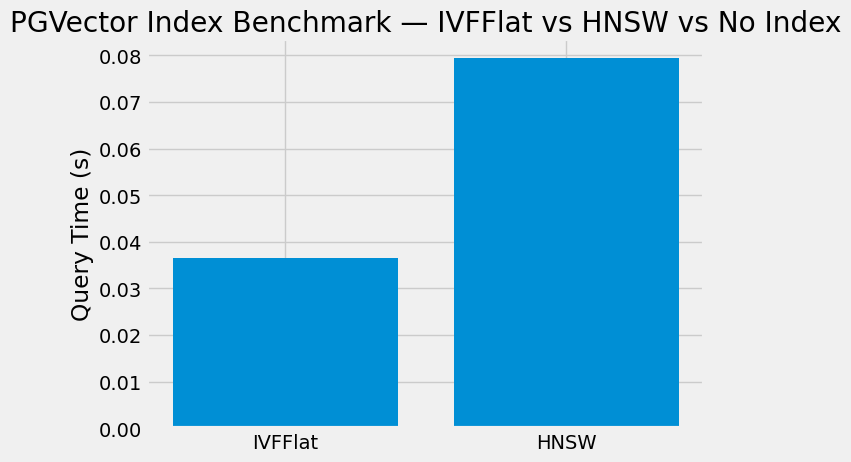

In [18]:
with plt.style.context("fivethirtyeight"):
    plt.bar(["IVFFlat", "HNSW"], [ivfflat_time, hnsw_time])
    plt.ylabel("Query Time (s)")
    plt.title("PGVector Index Benchmark — IVFFlat vs HNSW vs No Index")
    plt.show()

#### Graph of First Trial with 100k Entries.

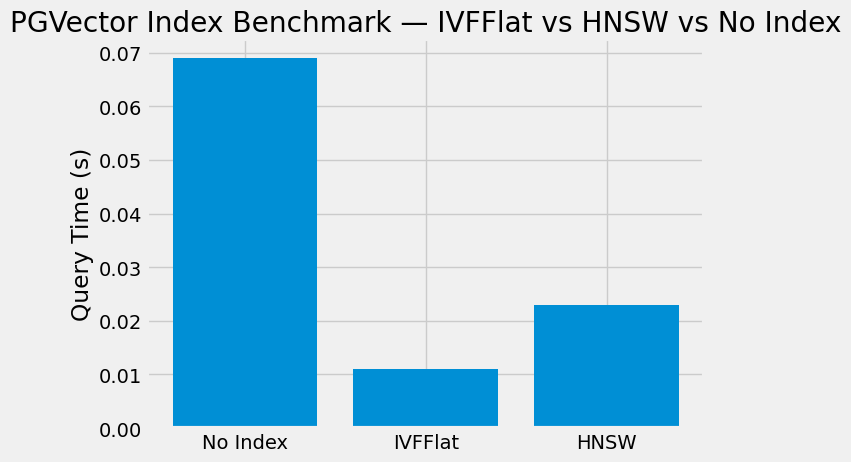

In [86]:
with plt.style.context("fivethirtyeight"):
    plt.bar(["No Index", "IVFFlat", "HNSW"], [no_index_time, ivfflat_time, hnsw_time])
    plt.ylabel("Query Time (s)")
    plt.title("PGVector Index Benchmark — IVFFlat vs HNSW vs No Index")
    plt.show()

## 13. Pros and Cons

## IVFFlat vs HNSW — Pros & Cons

| Feature | IVFFlat | HNSW |
|----------|----------|-------|
| **Algorithm** | Clustering-based (centroid + flat vectors) | Graph-based (hierarchical small-world) |
| **Speed** | Very fast with small `probes` | Fast and consistent |
| **Accuracy** | Depends on `lists` & `probes` | Usually higher |
| **Index Build Time** | Faster | Slower |
| **Memory Usage** | Lower | Higher (stores graph links) |
| **Supports incremental inserts** | Yes | Yes |
| **Good For** | Very large datasets (millions+) | High-accuracy search, dynamic data |
| **Best Metric** | L2 / Cosine | L2 / Cosine |

**Summary:**
- **IVFFlat** — great for large datasets (> 1 Mn) where approximate search is fine  
- **HNSW** — great for smaller or mid-size datasets (< 1 Mn) needing high recall